In [4]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.visualization import *
from src.evaluation import *
from src.data_augmentations import *
from src.m4_model import M4Model
from src.berken_loss import *
from src.m4_evaluation_loss_functions import *
from src.training_loss_functions import *


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
keras.backend.set_floatx('float64')

# Load Data

In [5]:
EPOCHS = 20
BATCH_SIZE = 120
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE =120
HIDDEN_LAYERS = 3
FEATURES_NUMBER = 1
CLIP_VALUE = 0.2
LEARNING_RATE = 0.002
DROPOUT_RATIO = 0.1


OUTPUT_SIZE = HORIZON*3
LOSS = BerkenLoss(HORIZON, BATCH_SIZE, weighted=True).loss()

x_augmentations = []
y_augmentations = []

train_path = "../Dataset/splitted/Hourly-train.csv"
test_path = "../Dataset/splitted/Hourly-test.csv"
train_holdout_path = "../Dataset/splitted/Hourly-train-holdout.csv"
test_holdout_path = "../Dataset/splitted/Hourly-test-holdout.csv"


data_loader = M4DataLoader(train_path, test_path, train_holdout_path, test_holdout_path,
                           x_augmentations, y_augmentations, LOOKBACK, HORIZON)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
holdout_x, holdout_y = data_loader.get_holdout_data()

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE, FEATURES_NUMBER)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE, FEATURES_NUMBER)
holdout_data_generator = M4Generator(holdout_x, holdout_y, BATCH_SIZE, FEATURES_NUMBER)

# Train The Model

In [22]:
model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, hidden_layers=HIDDEN_LAYERS,
                batch_size=BATCH_SIZE, lookback=LOOKBACK, 
                output_size=OUTPUT_SIZE, learning_rate=LEARNING_RATE, loss = LOSS,
                dropout_ratio = DROPOUT_RATIO, features_number = FEATURES_NUMBER, clipvalue=CLIP_VALUE, callbacks = [])

In [23]:
model.train(training_data_generator, test_data_generator, epochs=EPOCHS)

Epoch 1/20
43/43 [==============================] - 24s 566ms/step - loss: 10780.1282 - val_loss: 5069.6184
Epoch 2/20
43/43 [==============================] - 21s 480ms/step - loss: 4933.9277 - val_loss: 5634.3847
Epoch 3/20
43/43 [==============================] - 20s 472ms/step - loss: 4265.5744 - val_loss: 4386.2651
Epoch 4/20
43/43 [==============================] - 23s 526ms/step - loss: 3880.8045 - val_loss: 4386.2366
Epoch 5/20
43/43 [==============================] - 21s 492ms/step - loss: 3602.2651 - val_loss: 3382.5275
Epoch 6/20
43/43 [==============================] - 26s 599ms/step - loss: 2603.2246 - val_loss: 2657.5818
Epoch 7/20
43/43 [==============================] - 26s 606ms/step - loss: 2555.0153 - val_loss: 2895.9051
Epoch 8/20
43/43 [==============================] - 23s 536ms/step - loss: 2569.9811 - val_loss: 3481.3772
Epoch 9/20
43/43 [==============================] - 27s 618ms/step - loss: 2536.6288 - val_loss: 3001.9998
Epoch 10/20
43/43 [=================

##### Save The Model

In [2]:
MODEL_BASE_DIR = '../models/berken_weighted/2-LSTM'
model.save(MODEL_BASE_DIR)

NameError: name 'model' is not defined

# Get Best And Worst Predictions

Loaded model from disk
Best Predection Error is     2.7849
Worst Predection Error is    21.3381


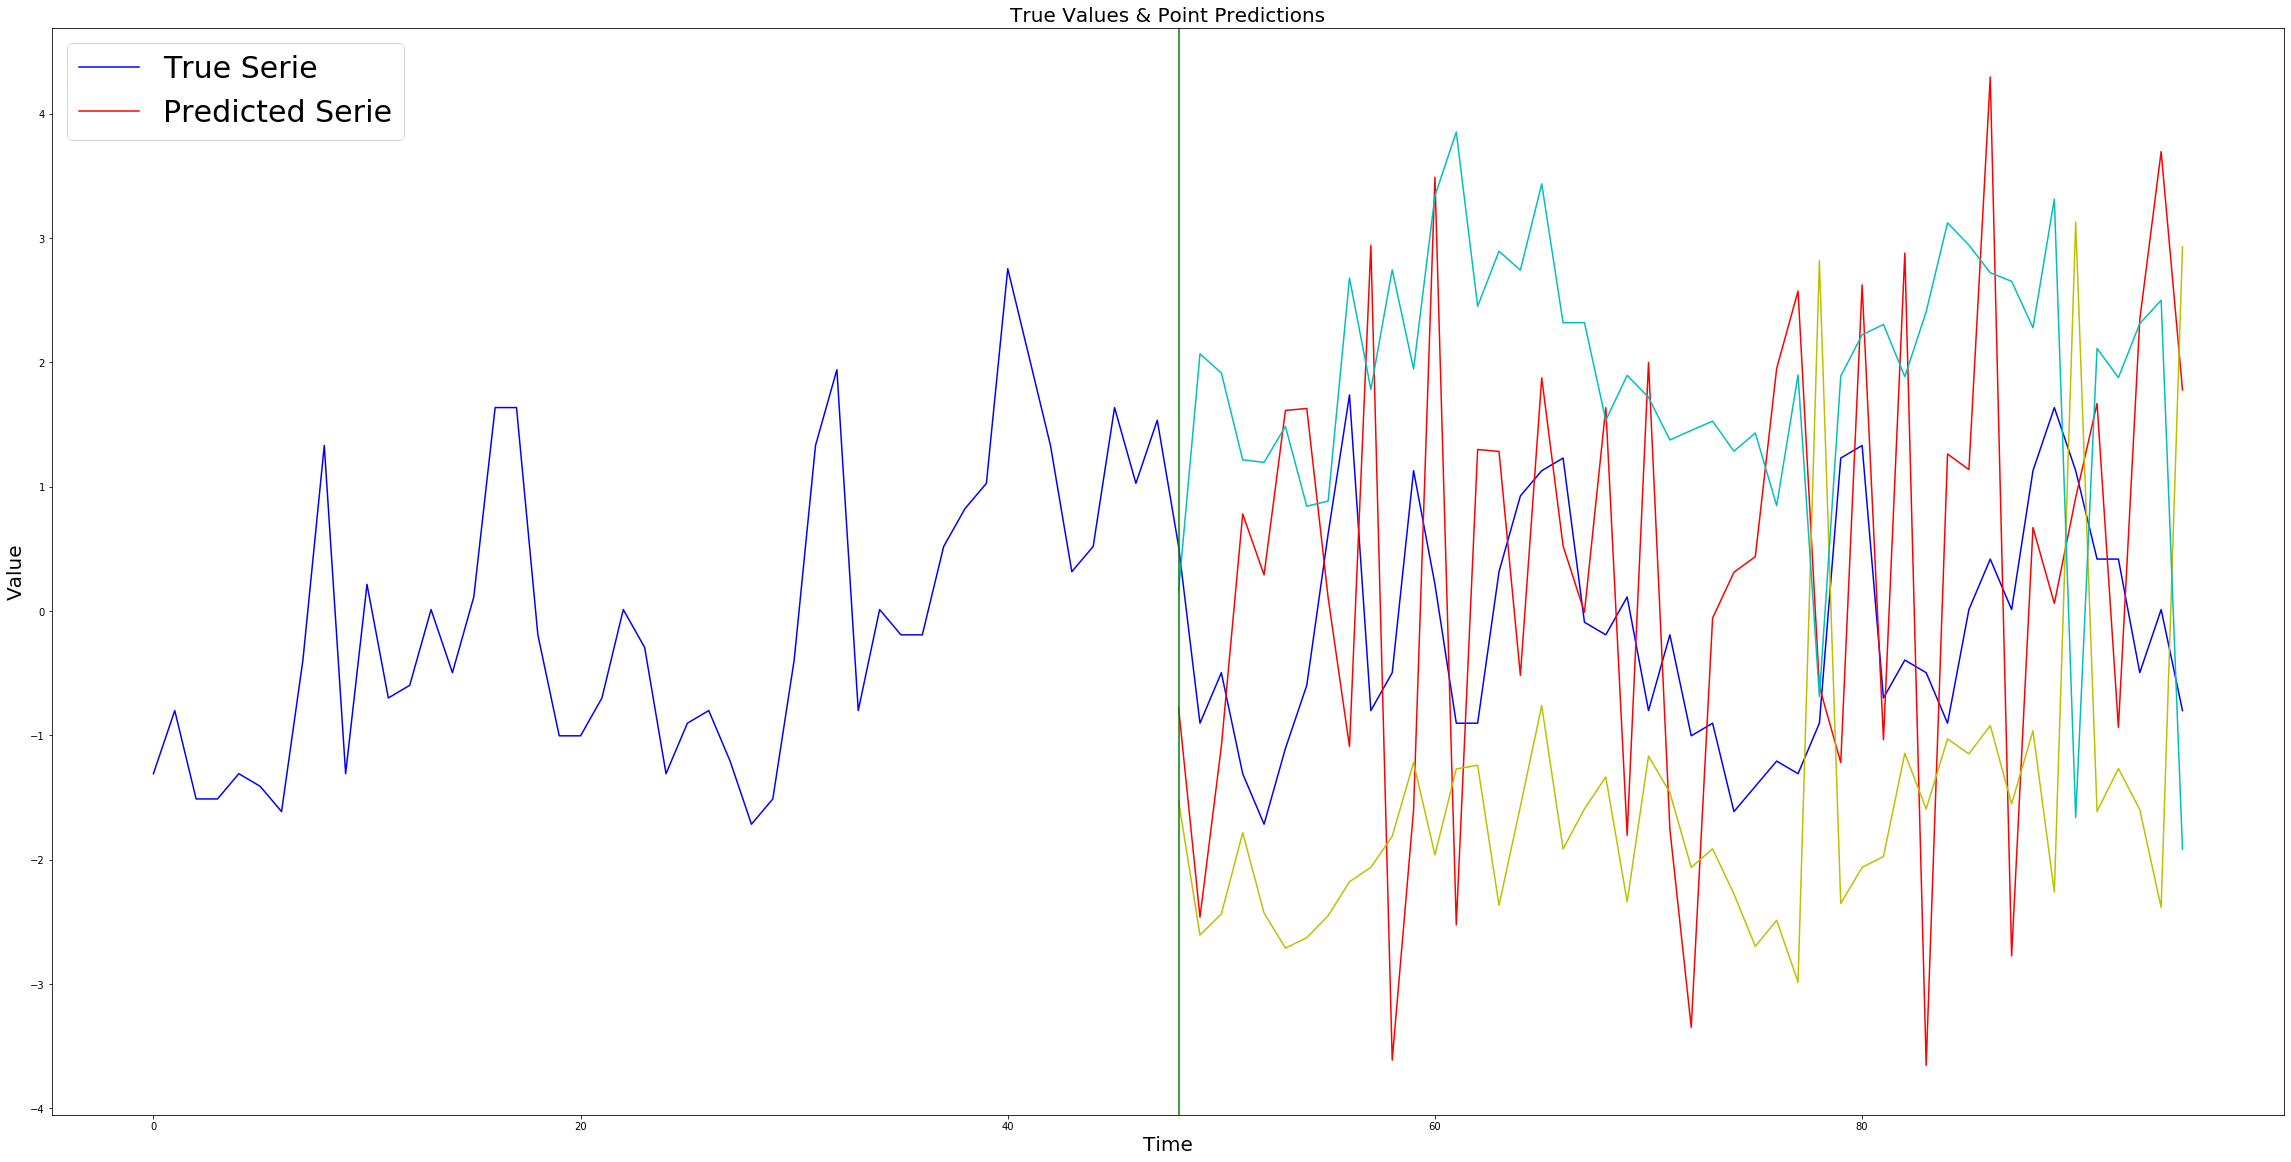

In [7]:
MODEL_BASE_DIR = '../models/berken_weighted/2-LSTM/2'
model = M4Model()
hyperparameters = model.load(MODEL_BASE_DIR)

X, Y, Ypredictions, error =  sort_by_prediction_error(model,holdout_x, holdout_y, mase)

if FEATURES_NUMBER == 1:
    X = X[:,:, np.newaxis]

print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[X.shape[0]-1]:10.4f}')

lower_bound = Ypredictions[:,-48:]
upper_bound = Ypredictions[:,48:-48]
plot_serie_with_bounds(X[:,:,0], Y[:,:HORIZON], Ypredictions[:,:HORIZON], lower_bound, upper_bound, serie_indx=0, save_path='best_berken_modified_holdout.png')
#plot_serie_with_bounds(X[:,:,0], Y[:,:HORIZON], Ypredictions[:,:HORIZON], lower_bound, upper_bound, serie_indx=X.shape[0]-1, save_path='worst_berken_weighted.png')


# PLot Specific Serie From A Batch

(0, 144)
(120, 144)
(120, 144)
(120, 144)
(240, 144)
(120, 144)


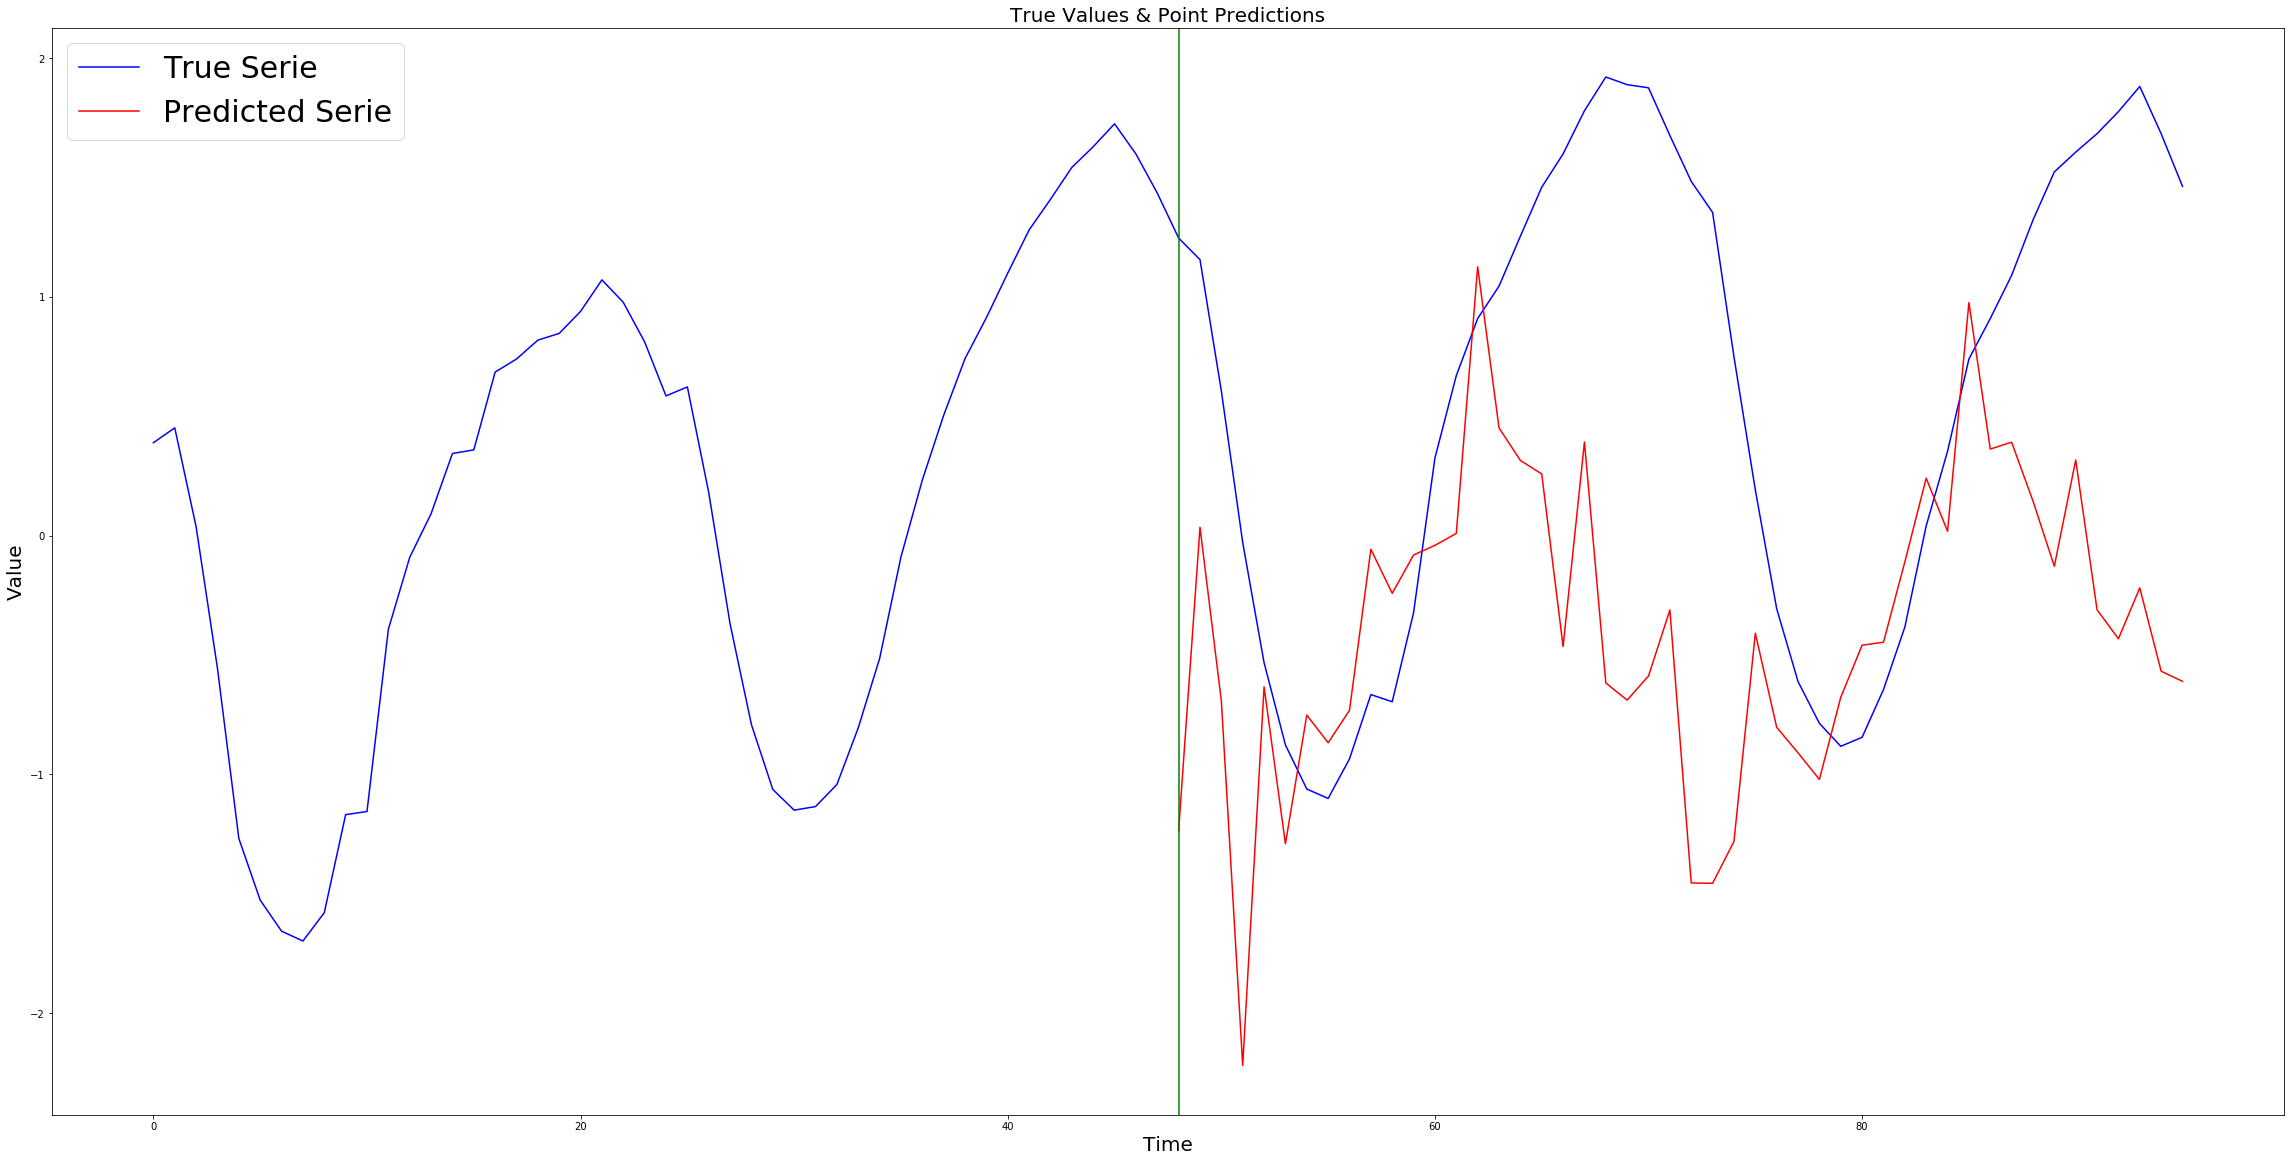

In [15]:
IDX = 40
X = test_x
Y = test_y
predictedY = model.predict(X)

if FEATURES_NUMBER == 1:
    X = X[:,:, np.newaxis]

#============ Predict Test
plot_serie_and_prediction(X[:,:,0], Y[:,:HORIZON], predictedY[:,:HORIZON], serie_indx=IDX)

# Evaluate A Model Against An Error Function

In [16]:
MODEL_NUMBER = 6
MODEL_BASE_DIR = '../models/berken/3-LSTM'
evaluation_results = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', 
                                             train_path, test_path, 
                                             train_holdout_path, test_holdout_path,
                                             x_augmentations, 
                                             y_augmentations, m4_mase)

print(f'Hyperparameters : {evaluation_results["hyperparameters"]}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["test_error"]}')
print(f'Naive Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["naive_test_error"]}')
      
print(f'SNaive Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["snaive_test_error"]}')

print(f'holdout Error For Model ({MODEL_NUMBER}) : {evaluation_results["holdout_error"]}')
print(f'Naive holdout Error For Model ({MODEL_NUMBER}) : {evaluation_results["naive_holdout_error"]}')
print(f'SNaive holdout Error For Model ({MODEL_NUMBER}) : {evaluation_results["snaive_holdout_error"]}')


Loaded model from disk
(0, 144)
(120, 144)
(120, 144)
(120, 144)
(240, 144)
(120, 144)
(0, 144)
(120, 144)
Hyperparameters : {'epochs': 1, 'learning_rate': 0.01, 'batch_size': 120, 'hidden_layer_size': 80, 'lookback': 48, 'loss': 'qd_objective_lstm_c', 'dropout_ratio': 0.2, 'features_number': 1, 'clipvalue': 0.5, 'output_size': 144, 'pi_params': {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}}
Test Error For Model (6) : 25.416
Naive Test Error For Model (6) : 23.825
SNaive Test Error For Model (6) : 1.805
holdout Error For Model (6) : 2.262
Naive holdout Error For Model (6) : 3.399
SNaive holdout Error For Model (6) : 1.569


# Evaluate Model PIs

In [20]:
model = M4Model()
model.load('../models/berken/3-LSTM/6')

y = test_y[:,:HORIZON]
x = test_x
print(x.shape)

predictedY = model.predict(test_x)
lower_bound = predictedY[:,:HORIZON] - 2*tf.abs(predictedY[:,-HORIZON:])
upper_bound = predictedY[:,:HORIZON] + 2*tf.abs(predictedY[:,-HORIZON:])

acd_err = acd(y, lower_bound.numpy(), upper_bound.numpy())
msis_err = msis(x, y, lower_bound.numpy(), upper_bound.numpy())

#Naive
y = test_y[:,:HORIZON]
lower, upper = naive_pi(y)
n_acd_err = acd( y[:,:-1], lower, upper)
n_msis_err = msis(test_x,  y[:,:-1], lower, upper)

print(f'Model ACD {acd_err}')
print(f'Model MSIS {msis_err}')
print(f'Naive ACD {n_acd_err}')
print(f'Naive MSIS {n_msis_err}')

Loaded model from disk
(331, 48)
(0, 144)
(120, 144)
(120, 144)
(120, 144)
(240, 144)
(120, 144)
Model ACD 0.03716012084592146
Model MSIS 282.9037919067307
Naive ACD 0.047171691200102894
Naive MSIS 94.1355872482457


# Predict  And Save
Get test and holdout predictions and save them in csv files

In [25]:
predict_and_save('../models/berken_weighted/3-LSTM/2', data_loader, HORIZON)

Loaded model from disk
